# K-NN Recommendation System

In [1]:
# Package pre-requisites
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Intro


In this project, I'll be building a recommendation system for a theoretical streaming service. While there are many different ways that this task can be done, I'll be focusing on implementing a K-Nearest Neighbors (KNN) algorithm. This will allow the theoretical streaming service to give recommendations for what a subject user should watch by using the ratings given by similar users to predict what the subject will rate a film they haven't seen yet.
## Purpose
A good algorithm is the heart of any modern content service. Whether it's short form video on platforms like Tik-Tok, music on a platform like Spotify, or TV and film on a platform like Netflix, a streaming service's job is to not just be the 'library' where users can find content, but to also be the 'librarian' who will actively help them find the content they may be interested in. A service that keeps users coming back will be one that knows what a user will enjoy *before* the user does. Where Blockbuster and other brick and mortar stores may have had film buffs working behind the counter who could recommend cult-classics and help customers discover new media, streaming services must rely on recommendation systems. With the large amount of user data available to a streaming service, especially with features such as user-ratings, we have all we need to understand each viewer's unique tastes. Giving a steady stream of good recommendations is key to continued user engagement, thus the success of any content platform begins with a good recommendation system. 

## Methodology
I'll be creating a K-Nearest Neighbors based system for our purposes here. In essence, we identify users with similar tastes to the subject user by finding their "distance" in a mathematical space where the user's rating for each film becomes one of the co-ordinates. Once we have identified those similar users, we determine what films they have seen which the subject user has not. By averaging the ratings of the similar users, we can predict what the subject will rate those unseen films, thus allowing us to sort the predicted results from highest to lowest rating, creating a list of top recommendations.

# Data Overview

For this project, I'll be working with the MovieLens Small Dataset. Since this is essentially intended to be a practice project, the small dataset is sufficiently large to demonstrate the relevant techniques, without being so large that operations will take significant amounts of time or processing power.

## Importing Data

In [2]:
movies_df = pd.read_csv("movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df = pd.read_csv("ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Exploring Data

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


We can immediately see that both datasets are complete (ie. no missing values). Additionally, the datatype of each column is correct.

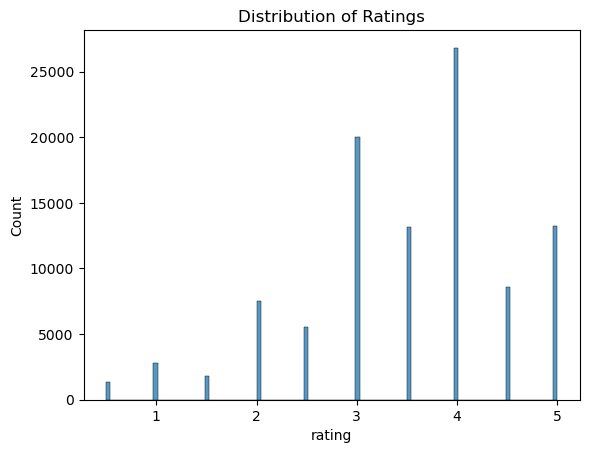

In [6]:
sns.histplot(x="rating",data=ratings_df)
plt.title("Distribution of Ratings")
plt.show()

Looking at the histogram of ratings, we can see that the distribution is discrete, only having half-step values (unsurprising for a star-based rating system). The results are fairly unsurprising; most movies are rated 3 or 4 stars, suggesting that the users who rated them were adequately entertained or moderately impressed. The distribution is left-skewed, with 4 stars being the most common rating. I'll point out that this dataset may be subject to several forms of bias, assuming that rating a movie is voluntary. This bias does not pose a problem for our purposes here, however. Passionate users may feel compelled to rate a film that they really enjoyed, but indifferent or bored users are more likely to not rate a film at all. Since we're not trying to create any kind of objective measure of "quality", but rather trying to predict the tastes of users, we can expect that the same biases will be present in the subject user's opinion on a film.

## Data Cleaning

Tasks:
- Drop unnecessary columns. Rating and timestamp will not be used in our system.
- Index dataframes by movieId to allow easier referencing.
- Add a "total ratings" column to the ratings dataframe
- Determine the average rating for each film in the database and add that as a new column to the movies dataframe

In [7]:
# Drop unnecessary columns
ratings_df.drop("timestamp", axis = 1, inplace = True)
movies_df.drop("genres",axis=1,inplace=True)

In [8]:
# Set ID to be the index
movies_df.set_index("movieId",inplace=True)
movies_df.head()

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [9]:
# Find the total number of ratings for each movie & assign to a new column
total_counts = ratings_df["movieId"].value_counts()
movies_df["ratingsCount"] = total_counts
movies_df.head()

,title,ratingsCount
movieId,,
1,Toy Story (1995),215.0
2,Jumanji (1995),110.0
3,Grumpier Old Men (1995),52.0
4,Waiting to Exhale (1995),7.0
5,Father of the Bride Part II (1995),49.0


In [10]:
# Find average ratings and add corresponding column
avg_ratings = ratings_df.groupby("movieId").mean()["rating"]
movies_df["averageRating"]=avg_ratings
movies_df.head()

,title,ratingsCount,averageRating
movieId,,,
1,Toy Story (1995),215.0,3.920930
2,Jumanji (1995),110.0,3.431818
3,Grumpier Old Men (1995),52.0,3.259615
4,Waiting to Exhale (1995),7.0,2.357143
5,Father of the Bride Part II (1995),49.0,3.071429


# Implementation

## K-Nearest Neighbors

A K-Nearest Neighbors recommendation system acts almost like an automated version of word of mouth. Rather than relying on professional ratings, or any kind of supervised learning, the idea is to cluster users based on taste, and use that to predict future ratings. The principle is that users who have enjoyed similar movies in the past will likely enjoy similar movies in the future.

## Finding ratings by userID

In [11]:
# By passing in a userId, we receive a list of the movies they have rated, and what those ratings were
def find_user_ratings(userId):
    user_ratings = ratings_df.query(f"userId=={userId}")
    return user_ratings[["movieId","rating"]].set_index("movieId")
    

## Find distance between users

Here, we'll be using linear algebra to generalize the idea of the distance between two points into a more abstract sense. Pythagorean theorem tells us that the distance between two points can be found using the equation 

d(p1,p2) = sqrt((p1_x-p2_x)^2+(p1_y-p2_y)^2)

Conceptually, the "a" and "b" legs of a right angle triangle are found by subtracting the x and y components of point 2 from the same components of point 1. Since "a^2+b^2 = c^2", where c is the hypotenuse (the straight line connecting the two points), finding the value of c will give us the straight-line distance between our points. That phrasing is inherently two dimensional, but we can easily abstract the idea to however many dimensions we want. Rather than hard-coding in the calculations, I'll be using the implementation in NumPy. 

In [12]:
def find_distance(id1,id2):
    ratings1, ratings2 = find_user_ratings(id1), find_user_ratings(id2)
    ratings_comparison = ratings1.join(ratings2, lsuffix="_1",rsuffix="_2").dropna() #This will give us a list of just movies both users have rated
    ratings1_paired, ratings2_paired = ratings_comparison["rating_1"], ratings_comparison["rating_2"]
    distance = np.linalg.norm(ratings1_paired-ratings2_paired)
    return [id2,distance]

## Find top similar users

Using the function defined above, we can calculate the distance between a given user and every other user in the database, then return the top matches. We'll first define a function to find *every* distance.

In [13]:
def find_all_distances(userId):
    users = ratings_df["userId"].unique()
    users = users[users != userId] # Don't want to compare against yourself
    distances = [find_distance(userId, id) for id in users]
    distance_df = pd.DataFrame(distances, columns = ["OtherId","distance"])
    distance_df = distance_df.sort_values("distance")
    distance_df = distance_df.set_index("OtherId")
    return distance_df

In [14]:
def find_k_nearest_neighbors(userId, k=5):
    distances = find_all_distances(userId).head(k)
    return distances

In [15]:
find_k_nearest_neighbors(1,10)

,distance
OtherId,
306,0.0
578,0.0
556,0.0
77,0.0
85,0.0
175,0.0
253,0.0
291,0.0
506,0.0


Thus we have a function which allows us to find the top K users with the most similar tastes.

## Make Recommendation

Finally, we recommend a selection of movies by finding the top similar users, then we find the average rating among similar users. We sort the results by the total number of ratings, considering the fact that the more ratings there are, the more certain we can be regarding the how the subject will feel about a particular film.

In [57]:
def make_recommendation(userId):
    neighbors = find_k_nearest_neighbors(userId)
    ratings_by_index = ratings_df.set_index("userId")
    top_similar_ratings = ratings_by_index.loc[neighbors.index]
    top_similar_ratings_average = top_similar_ratings.groupby("movieId").mean()[["rating"]]
    recommended_movie = top_similar_ratings_average.sort_values("rating",ascending=False)
    #Drop movies user has already seen
    seen_list = find_user_ratings(userId).index
    for mov in seen_list:
        if mov in recommended_movie.index:
            recommended_movie.drop(index=mov,inplace=True)
    return recommended_movie.join(movies_df).sort_values("ratingsCount",ascending=False)

In [59]:
make_recommendation(1)

,rating,title,ratingsCount,averageRating
movieId,,,,
4993,4.75,"Lord of the Rings: The Fellowship of the Ring,...",198.0,4.106061
5952,4.50,"Lord of the Rings: The Two Towers, The (2002)",188.0,4.021277
7153,4.50,"Lord of the Rings: The Return of the King, The...",185.0,4.118919
588,5.00,Aladdin (1992),183.0,3.792350
2762,3.00,"Sixth Sense, The (1999)",179.0,3.893855
...,...,...,...,...
149334,3.00,Nocturnal Animals,1.0,3.000000
75446,2.50,Little Ashes (2008),1.0,2.500000
158528,2.50,The Shallows (2016),1.0,2.500000


# Evaluation

In order to determine the effectiveness of the recommendation algorithm, we can find a user who has a rated a large number of films, then split their ratings into a training and test set. With this done, we may then generate a list of predicted ratings using the K-Nearest Neighbors. Computing the correlation between observed values and predicted values on a normal-normal distribution plot will allow us to quantify how well the user's tastes were modeled. (???)